In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
from typing import Iterator

In [3]:
def read_jsonl(file_name: str) -> Iterator:
    with open(file_name, mode="r", encoding="utf-8") as f:
        for line in f:
            yield json.loads(line)

def read_results_file(fn):
    num_digits = []
    num_terms = []
    num_samples_total = 0

    for x in read_jsonl(fn):
        num_digits.append(x["num_digits"])
        num_terms.append(x["num_terms"])
        num_samples_total += 1

    num_digits_max = max(num_digits)
    num_digits_min = min(num_digits)
    num_terms_max = max(num_terms)
    num_terms_min = min(num_terms)

    h = num_digits_max-num_digits_min+1
    w = num_terms_max-num_terms_min+1
    solved = np.zeros((h, w), dtype=np.int32)
    counts = np.zeros_like(solved)

    for x in read_jsonl(fn):
        d = int(x["num_digits"]) - num_digits_min
        t = int(x["num_terms"]) - num_terms_min
        s = bool(x["solved"])
        if s:
            solved[d, t] += 1
        counts[d, t] += 1
        
    rates = solved / counts
    return rates, num_digits_min, num_digits_max, num_terms_min, num_terms_max

def plt_heatmap(title, rates, num_digits_min, num_digits_max, num_terms_min, num_terms_max):
    plt.figure(figsize=(6, 4))
    sns.heatmap(rates, 
                annot=True,  # Show values in cells
                fmt='.2f',   # Format to 2 decimal places
                cmap='viridis',  # Color scheme
                cbar=True,
                xticklabels=list(range(num_terms_min, num_terms_max+1)),
                yticklabels=list(range(num_digits_min, num_digits_max+1))
                )    # Show colorbar

    # Optional: Add title and labels
    plt.title(title)
    plt.xlabel('num_terms')
    plt.ylabel('num_digits')

    # Display the plot
    plt.tight_layout()
    plt.show()

def show_rates(fn):
    rates, num_digits_min, num_digits_max, num_terms_min, num_terms_max = read_results_file(fn)
    plt_heatmap(fn, rates, num_digits_min, num_digits_max, num_terms_min, num_terms_max)


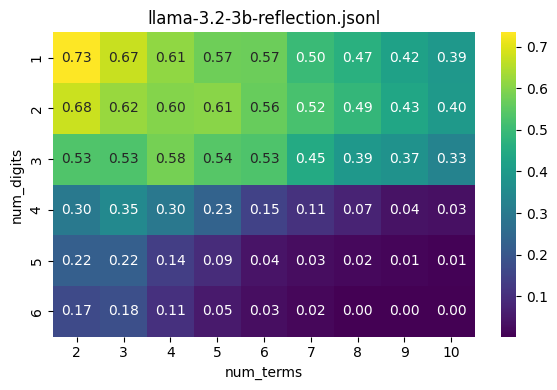

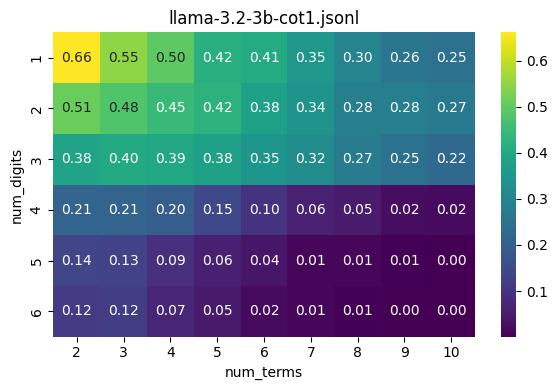

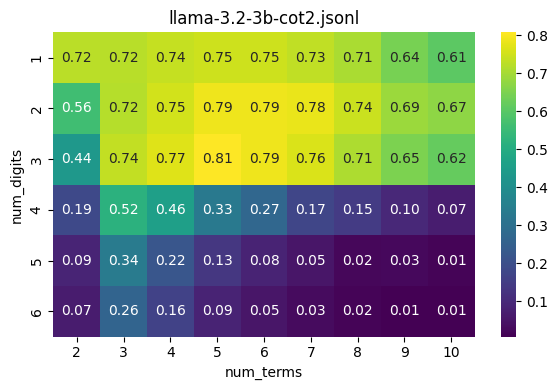

In [5]:
fns = ["llama-3.2-3b-reflection.jsonl", "llama-3.2-3b-cot1.jsonl", "llama-3.2-3b-cot2.jsonl"]
for fn in fns:
    show_rates(fn)

In [6]:
def read_provider_stats(fn):
    finish_reasons = {}
    total_rows = 0
    solved = 0
    completion_tokens = []
    completion_tokens_solved = []
    solved_by_provider = {}
    total_by_provider = {}
    for x in read_jsonl(fn):
        total_rows += 1
        fr = x["finish_reason"]
        finish_reasons[fr] = finish_reasons.get(fr, 0) + 1
        p = x["provider"]
        if x["solved"]:
            solved += 1
            completion_tokens_solved.append(x["completion_tokens"])
            solved_by_provider[p] = solved_by_provider.get(p, 0) + 1
        completion_tokens.append(x["completion_tokens"])
        total_by_provider[p] = total_by_provider.get(p, 0) + 1
    
    return finish_reasons, total_rows, solved, completion_tokens, completion_tokens_solved, solved_by_provider, total_by_provider
    

In [34]:
def plot_finish_reason(fn, finish_reasons):
    # Prepare the data
    reasons = [str(reason) if reason is not None else 'None' for reason in finish_reasons.keys()]
    counts = list(finish_reasons.values())

    # Calculate percentages
    total = sum(counts)
    percentages = [count/total * 100 for count in counts]

    # Create the bar chart
    fig, ax = plt.subplots(figsize=(5, 3))

    # Create bars with a nice color
    bars = ax.bar(reasons, counts, color='#2E86C1')

    # Customize the chart
    plt.title(f'Distribution of Finish Reasons ({fn})', fontsize=14, pad=20)
    plt.xlabel('Finish Reason', fontsize=12)
    plt.ylabel('Count', fontsize=12)

    # Add value labels on top of each bar with both count and percentage
    for bar in bars:
        height = bar.get_height()
        percentage = (height/total) * 100
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{int(height)}\n({percentage:.1f}%)',
                ha='center', va='bottom')

    # Add a grid for better readability
    ax.grid(True, axis='y', linestyle='--', alpha=0.7)

    # Set reasonable y-axis limits to ensure all bars are visible
    ax.set_ylim(0, max(counts) * 1.1)  # Add 10% padding at the top

    # Adjust layout to prevent label cutoff
    plt.tight_layout()

    # Show the plot
    plt.show()

def plot_success_rate(fn, solved_by_provider, total_by_provider):
    # Prepare the data
    providers = list(solved_by_provider.keys())
    solved_values = [solved_by_provider[provider] for provider in providers]
    total_values = [total_by_provider[provider] for provider in providers]

    # Calculate the percentage
    percentages = [s/t * 100 for s, t in zip(solved_values, total_values)]

    # Create the bar chart
    fig, ax = plt.subplots(figsize=(6, 3))

    # Create bars
    bars = ax.bar(providers, percentages)

    # Customize the chart
    plt.title(f'Success Rate by Provider ({fn})', fontsize=14, pad=20)
    plt.xlabel('Provider', fontsize=12)
    plt.ylabel('Success Rate (%)', fontsize=12)

    # Rotate x-axis labels for better readability
    plt.xticks(rotation=45, ha='right')

    # Add value labels on top of each bar
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.1f}%',
                ha='center', va='bottom')

    # Add a grid for better readability
    ax.grid(True, axis='y', linestyle='--', alpha=0.7)

    # Adjust layout to prevent label cutoff
    plt.tight_layout()

    # Show the plot
    plt.show()

def plot_completion_tokens(fn, completion_tokens, bins=100):
    plt.figure(figsize=(12, 6))

    # Create histogram
    plt.hist(completion_tokens, bins=bins, color='#2E86C1', alpha=0.7, edgecolor='white')

    # Customize the chart
    plt.title(f'Distribution of Completion Tokens ({fn})', fontsize=14, pad=20)
    plt.xlabel('Number of Tokens', fontsize=12)
    plt.ylabel('Frequency', fontsize=12)

    # Add grid for better readability
    plt.grid(True, axis='y', linestyle='--', alpha=0.3)

    # Add mean and median lines
    mean_tokens = np.mean(completion_tokens)
    median_tokens = np.median(completion_tokens)

    plt.axvline(mean_tokens, color='red', linestyle='dashed', linewidth=1)
    plt.text(mean_tokens*1.02, plt.gca().get_ylim()[1]*0.95, 
            f'Mean: {mean_tokens:.1f}', color='red')

    plt.axvline(median_tokens, color='green', linestyle='dashed', linewidth=1)
    plt.text(median_tokens*1.02, plt.gca().get_ylim()[1]*0.85, 
            f'Median: {median_tokens:.1f}', color='green')

    # Adjust layout
    plt.tight_layout()

    # Show plot
    plt.show()

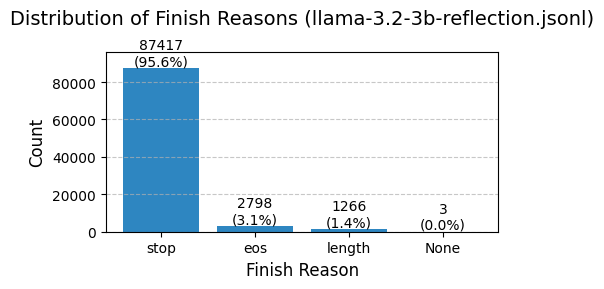

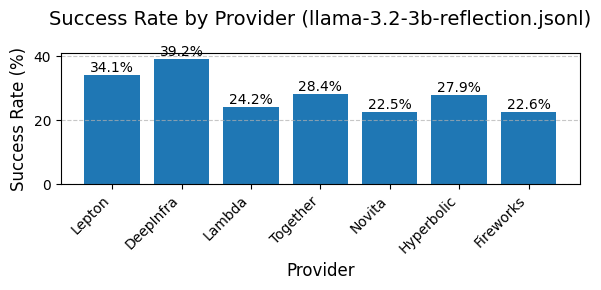

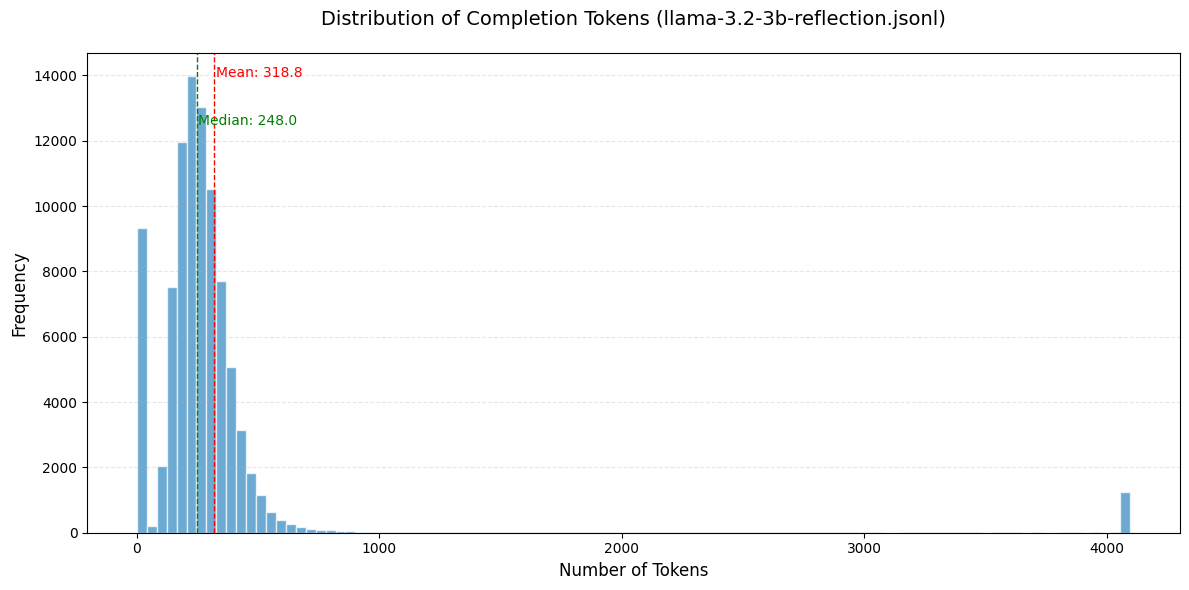

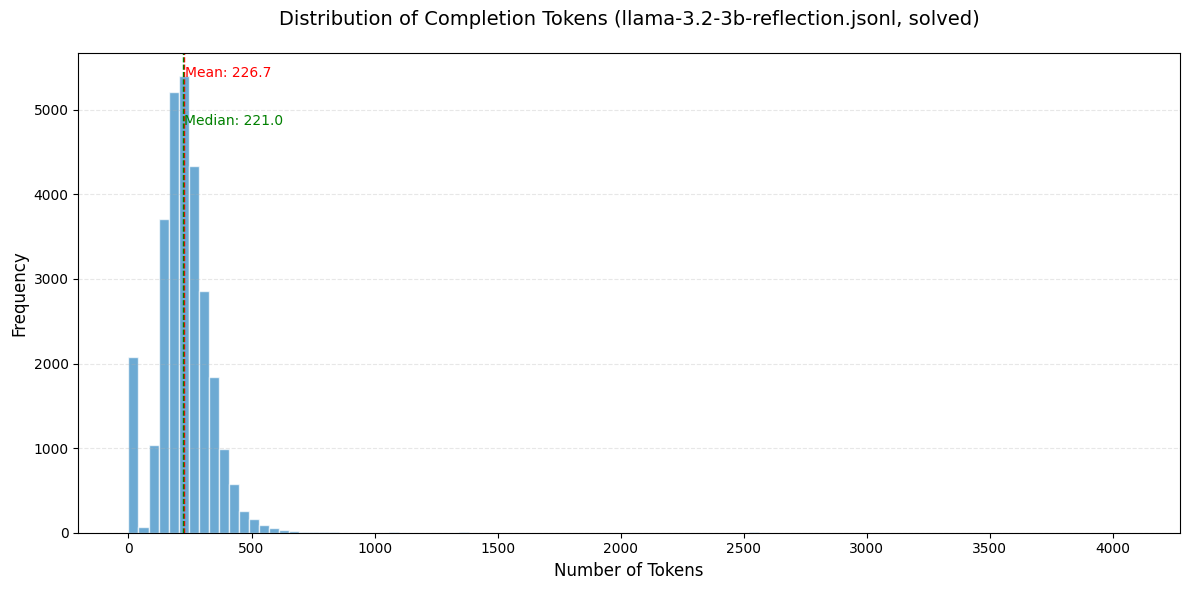

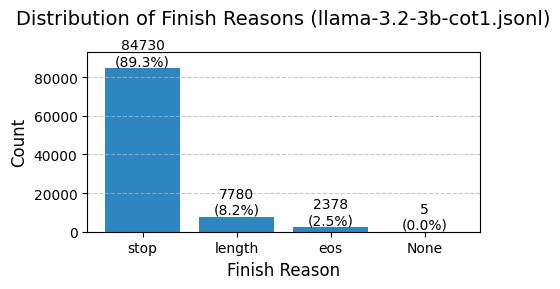

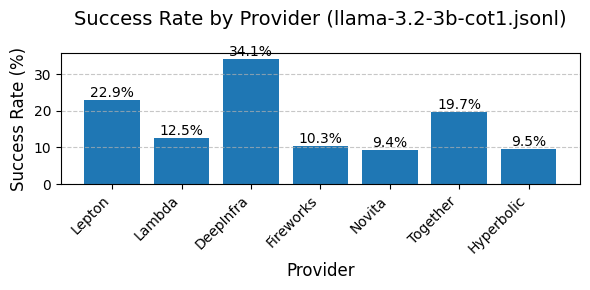

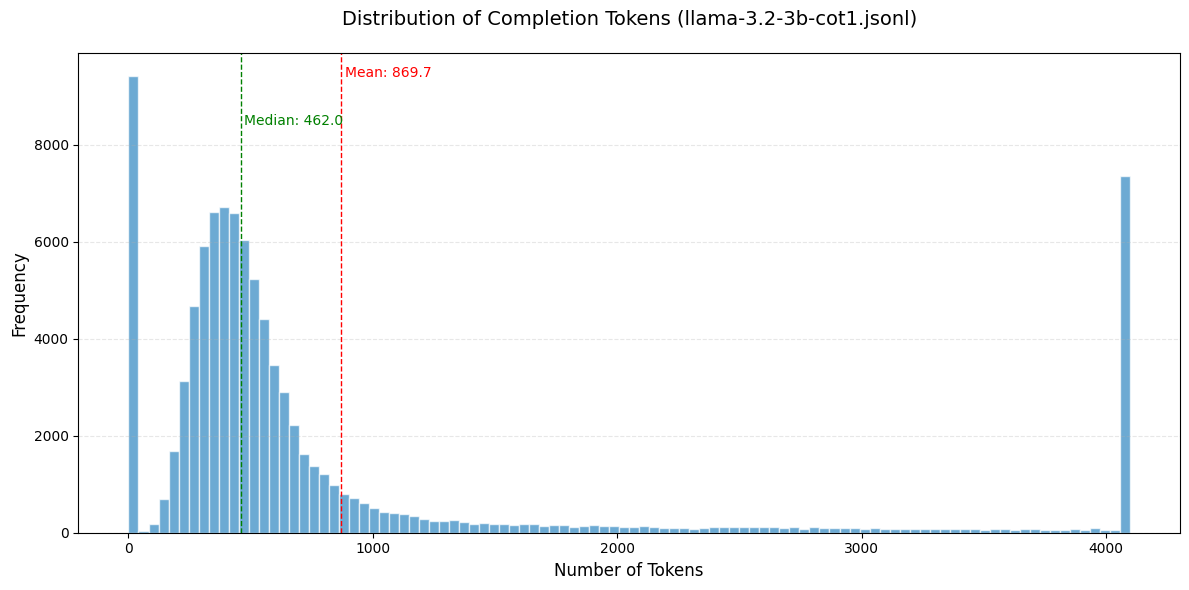

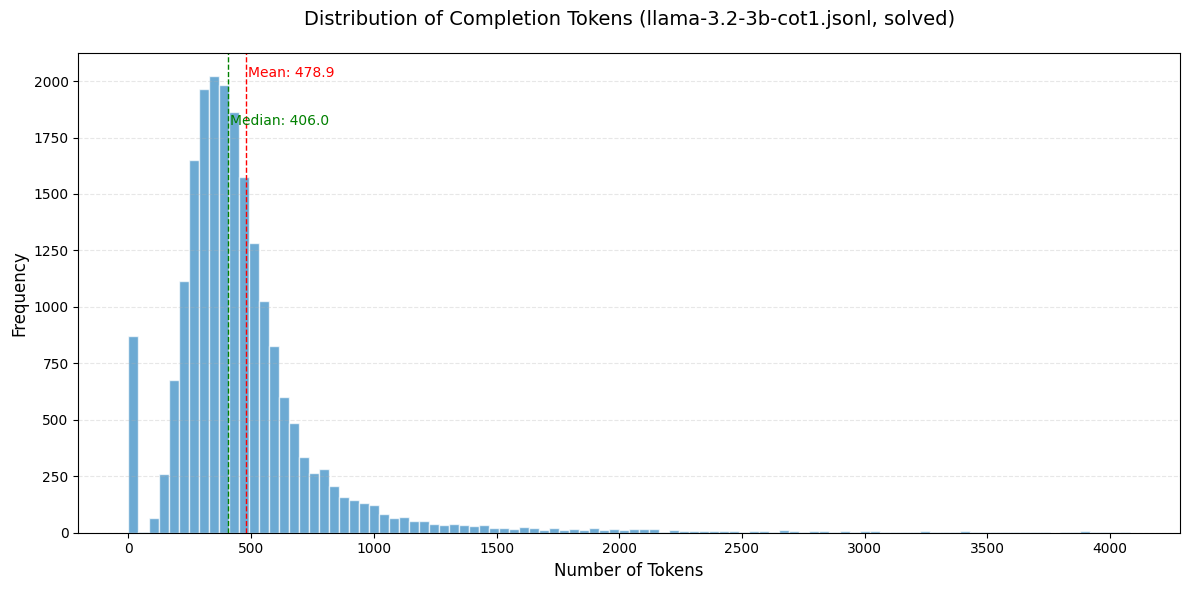

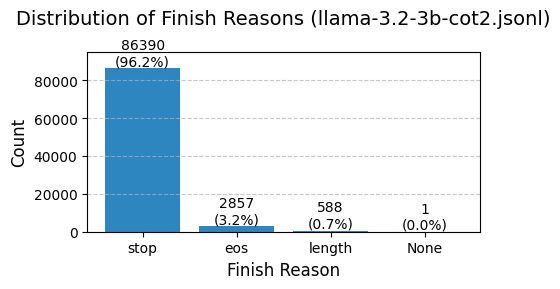

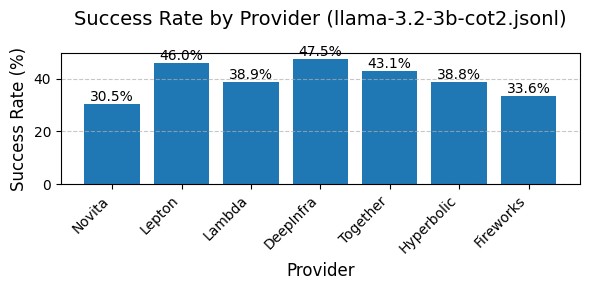

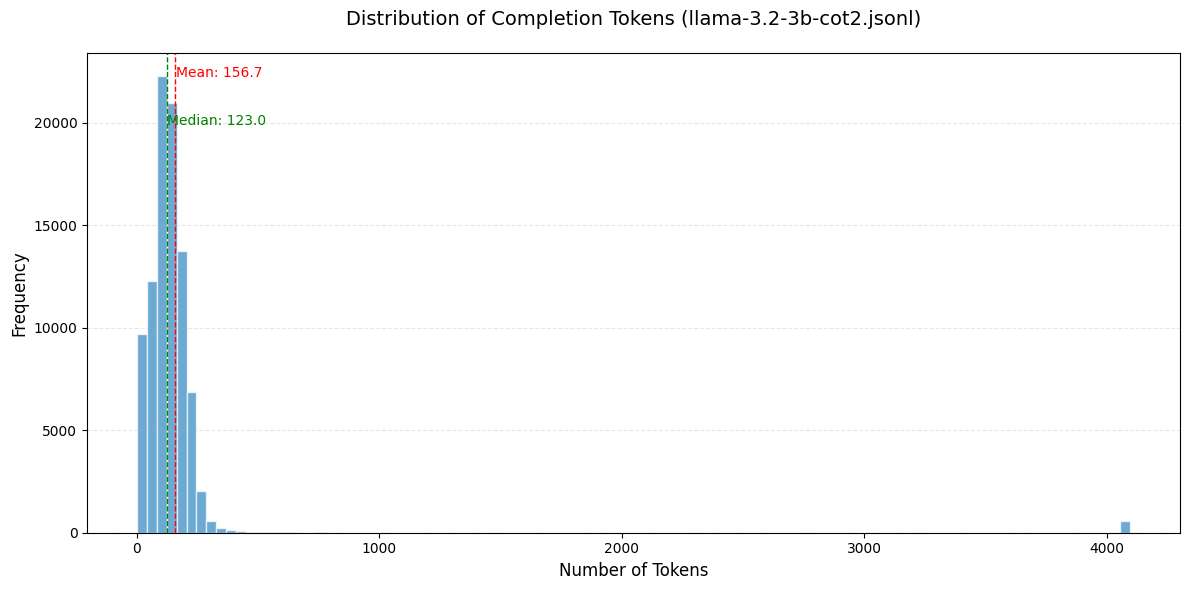

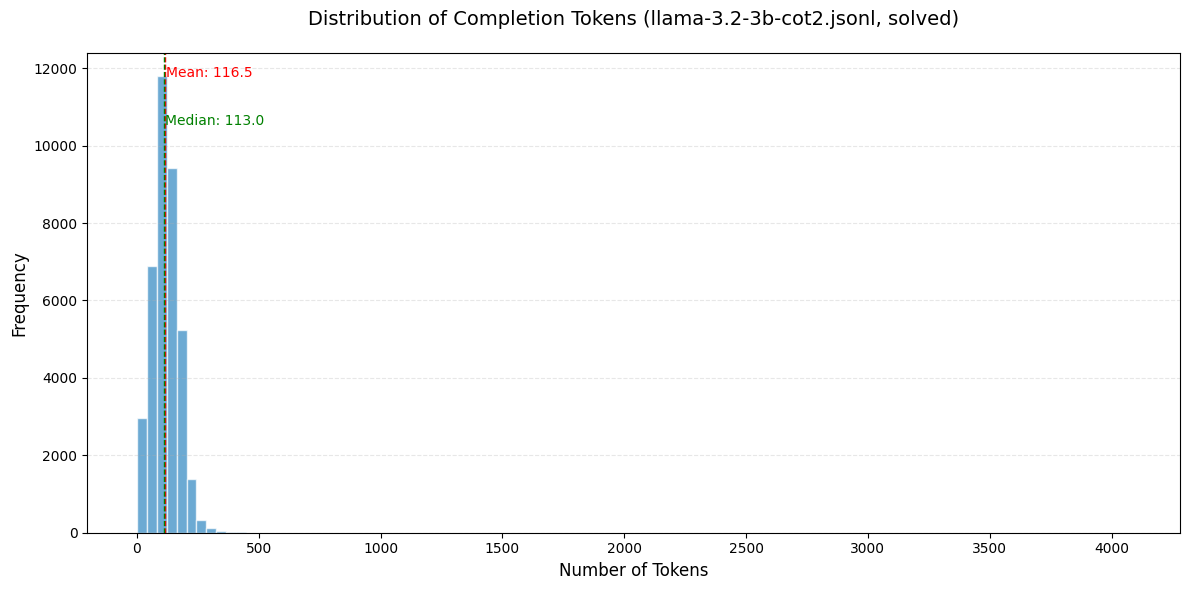

In [35]:
for fn in fns:
    finish_reasons, total_rows, solved, completion_tokens, completion_tokens_solved, solved_by_provider, total_by_provider = read_provider_stats(fn)
    plot_finish_reason(fn, finish_reasons)
    plot_success_rate(fn, solved_by_provider=solved_by_provider, total_by_provider=total_by_provider)
    plot_completion_tokens(fn, completion_tokens)
    plot_completion_tokens(fn + ", solved", completion_tokens_solved)